In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [24]:
# 1. DATA INGESTION
df = pd.read_csv("./improved_reservations.csv", parse_dates=["date"])
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           70128 non-null  datetime64[ns]
 1   year           70128 non-null  int64         
 2   month          70128 non-null  int64         
 3   day            70128 non-null  int64         
 4   day_of_week    70128 non-null  int64         
 5   is_weekend     70128 non-null  int64         
 6   special_event  70128 non-null  int64         
 7   hour_of_day    70128 non-null  int64         
 8   guest_count    70128 non-null  int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 4.8 MB


(        date  year  month  day  day_of_week  is_weekend  special_event  \
 0 2018-01-01  2018      1    1            0           0              0   
 1 2018-01-01  2018      1    1            0           0              0   
 2 2018-01-01  2018      1    1            0           0              0   
 3 2018-01-01  2018      1    1            0           0              0   
 4 2018-01-01  2018      1    1            0           0              0   
 
    hour_of_day  guest_count  
 0            0           20  
 1            1           19  
 2            2           18  
 3            3           17  
 4            4           20  ,
 None)

In [25]:
# 2. FEATURE ENGINEERING
df['year']        = df['date'].dt.year
df['month']       = df['date'].dt.month
df['day_of_week'] = df['date'].dt.weekday
df['is_weekend']  = (df['day_of_week'] >= 5).astype(int)
# Cyclical encoding
df['hour_sin'] = np.sin(2 * np.pi * df.hour_of_day / 24)
df['hour_cos'] = np.cos(2 * np.pi * df.hour_of_day / 24)
df['dow_sin']  = np.sin(2 * np.pi * df.day_of_week / 7)
df['dow_cos']  = np.cos(2 * np.pi * df.day_of_week / 7)
# One-hot month
month_ohe = OneHotEncoder(sparse_output=False, drop='first')
months_enc = month_ohe.fit_transform(df[['month']])
month_cols = [f'month_{m}' for m in month_ohe.categories_[0][1:]]
df = pd.concat([df, pd.DataFrame(months_enc, columns=month_cols, index=df.index)], axis=1)

In [26]:
# 3. TIME-AWARE SPLIT
df = df.sort_values('date')
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df  = df.iloc[split_idx:]

In [27]:
# 4. PREPARE MATRICES & SCALING
feature_cols = ['is_weekend','special_event','hour_sin','hour_cos','dow_sin','dow_cos'] + month_cols
X_train = train_df[feature_cols]; y_train = train_df['guest_count']
X_test  = test_df[feature_cols];  y_test  = test_df['guest_count']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
# 5. MODEL DEFINITION & INITIAL CV
models = {
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'RandomForest':     RandomForestRegressor(random_state=42),
    'LinearReg':        LinearRegression(),
    'SVR':              SVR(),
    'KNN':              KNeighborsRegressor(),
    'PoissonReg':       PoissonRegressor(alpha=1e-6, max_iter=1000),
}
tscv = TimeSeriesSplit(n_splits=5)
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train,
                             cv=tscv, scoring='neg_root_mean_squared_error')
    cv_results[name] = -scores.mean()
    print(f"{name} CV RMSE: {cv_results[name]:.3f}")

GradientBoosting CV RMSE: 11.089
RandomForest CV RMSE: 9.612
LinearReg CV RMSE: 21.012


In [ ]:
# 6. HYPERPARAMETER TUNING FOR GB
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}
gb = GradientBoostingRegressor(random_state=42)
random_search = RandomizedSearchCV(gb, param_distributions=param_dist,
                                   n_iter=10, cv=tscv,
                                   scoring='neg_root_mean_squared_error',
                                   random_state=42)
random_search.fit(X_train_scaled, y_train)
print("Best GB params:", random_search.best_params_)
best_gb = random_search.best_estimator_
# Save the model, scaler, and month encoder
joblib.dump(best_gb, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(month_ohe, 'month_ohe.pkl')
models['GB_Tuned'] = best_gb
cv_results['GB_Tuned'] = -random_search.best_score_

Best GB params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


In [ ]:
# 7. FINAL TRAIN & EVALUATION
results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_tr = model.predict(X_train_scaled)
    y_te = model.predict(X_test_scaled)
    results.append({
        'Model':       name,
        'CV RMSE':     cv_results[name],
        'Train RMSE':  np.sqrt(mean_squared_error(y_train, y_tr)),
        'Test RMSE':   np.sqrt(mean_squared_error(y_test , y_te)),
        'Train MAE':   mean_absolute_error(y_train, y_tr),
        'Test MAE':    mean_absolute_error(y_test , y_te),
        'Train R2':    r2_score(y_train, y_tr),
        'Test R2':     r2_score(y_test , y_te),
    })

results_df = pd.DataFrame(results).set_index('Model')
results_df

,CV RMSE,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2
Model,,,,,,,
GradientBoosting,11.013718,8.615183,13.270332,6.199470,8.288865,0.903703,0.800184
RandomForest,11.331029,6.263174,12.879604,4.155772,8.661427,0.949105,0.811778
LinearReg,23.356707,23.693787,25.299244,21.191847,22.464972,0.271627,0.273759
SVR,26.653576,27.071337,29.869847,21.701324,23.447298,0.049167,-0.012353
KNN,21.432842,17.571954,25.103526,13.362750,19.497000,0.599387,0.284952
PoissonReg,22.307302,22.663971,24.604378,20.231538,21.530738,0.333566,0.313104
GB_Tuned,11.013718,8.615183,13.270332,6.199470,8.288865,0.903703,0.800184


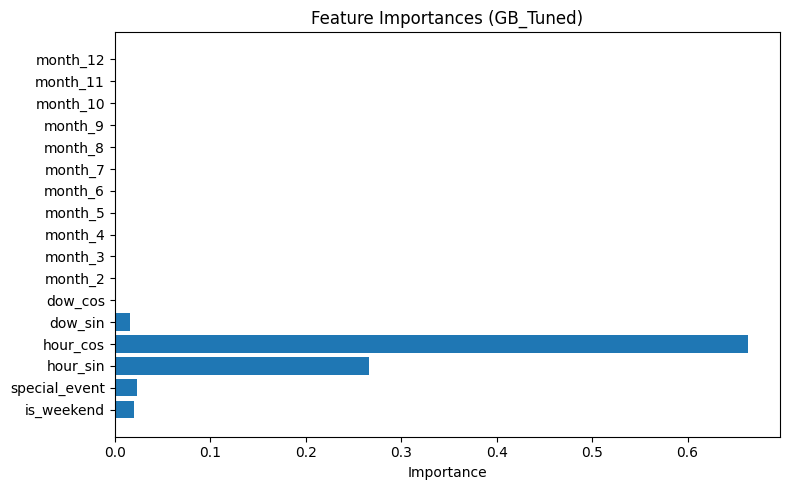

In [ ]:
# 8. FEATURE IMPORTANCE (for GB_Tuned)
fi = best_gb.feature_importances_
plt.figure(figsize=(8,5))
plt.barh(feature_cols, fi)
plt.title('Feature Importances (GB_Tuned)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

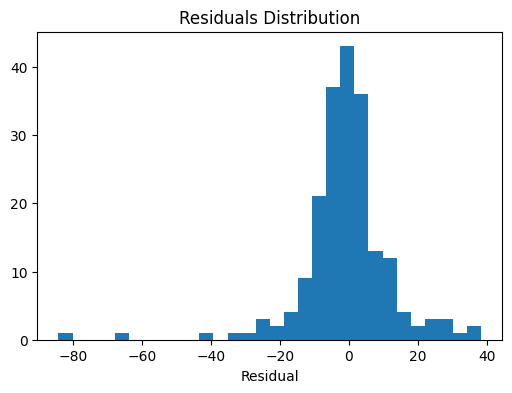

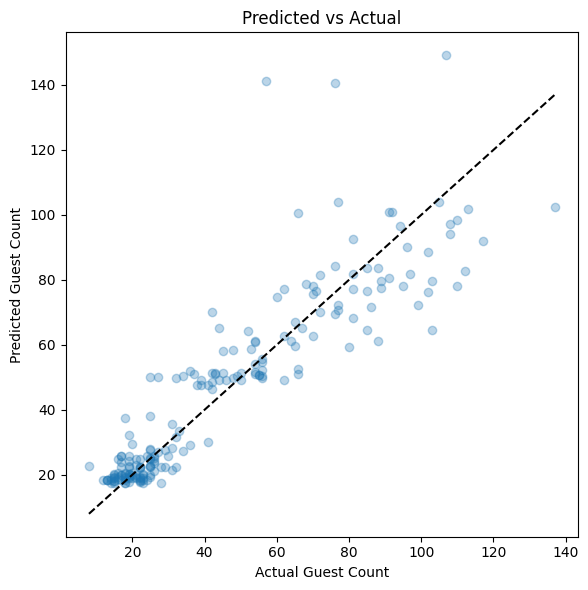

In [ ]:
# 9. RESIDUAL ANALYSIS (GB_Tuned)
y_pred = best_gb.predict(X_test_scaled)
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'k--')
plt.title('Predicted vs Actual')
plt.xlabel('Actual Guest Count')
plt.ylabel('Predicted Guest Count')
plt.tight_layout()
plt.show()

C:\Users\wsmtr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
C:\Users\wsmtr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
C:\Users\wsmtr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
C:\Users\wsmtr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packag

   hour  pred_guest_count
0    10         22.085120
1    11         22.662947
2    12         65.451463
3    13         58.452903
4    14         58.879270
5    15         22.917143
6    16         22.917143
7    17         22.817059
8    18        105.785203
9    19         99.339149


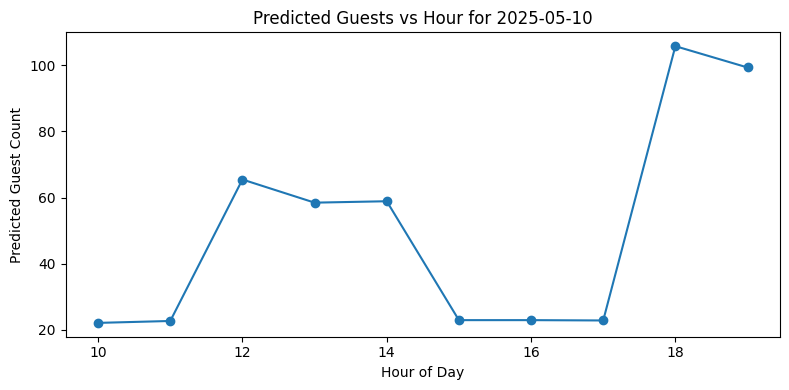

In [ ]:
# 10. INFERENCE HELPER
def make_features(dt, special_event=0):
    d = pd.to_datetime(dt)
    data = {
        'is_weekend': int(d.weekday()>=5),
        'special_event': special_event,
        'hour_sin': np.sin(2*np.pi*d.hour/24),
        'hour_cos': np.cos(2*np.pi*d.hour/24),
        'dow_sin':  np.sin(2*np.pi*d.weekday()/7),
        'dow_cos':  np.cos(2*np.pi*d.weekday()/7),
        'month':    d.month
    }
    month_vec = month_ohe.transform([[data['month']]])[0]
    for i, col in enumerate(month_cols):
        data[col] = month_vec[i]
    df_new = pd.DataFrame([data])
    X_new = df_new[['is_weekend','special_event','hour_sin','hour_cos','dow_sin','dow_cos'] + month_cols]
    return scaler.transform(X_new)

# 11. BATCH PREDICTION FUNCTION
def predict_range(date_str, hour_start, hour_end, special_event=0):
    hours = list(range(hour_start, hour_end + 1))
    preds = []
    for hr in hours:
        dt = f"{date_str} {hr:02d}:00"
        feat = make_features(dt, special_event)
        preds.append(best_gb.predict(feat)[0])
    return pd.DataFrame({'hour': hours, 'pred_guest_count': preds})

# Example usage
df_pred = predict_range('2025-05-10', 10, 19)
print(df_pred)

plt.figure(figsize=(8,4))
plt.plot(df_pred.hour, df_pred.pred_guest_count, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Predicted Guest Count')
plt.title('Predicted Guests vs Hour for 2025-05-10')
plt.tight_layout()
plt.show()